In [2]:
import argparse
import numpy as np
import os
import pickle
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
#
from ctrf.metrics import *
from ctrf.models import *
from ctrf.auction import *

In [3]:
class Args:
  seed = 40
  n_tr_samples = 30000
  n_te_cnt_samples = 100000
  n_te_trt_samples = 100000
  n_te_rnd_samples = 100000
  n_features = 11
  n_informative = 10
  n_clusters_per_class = 10
  class_sep = 1
  oracle_n_estimators = 100
  oracle_min_samples_leaf = 100
  auction_n_estimators = 50
  auction_max_leaf_nodes = 100
  auction_size = 20
  n_rnd_auction = 10000
  n_auctions = 25000
  epsilon = .1
  control_reserve = .5
  treatment_reserve = .8
  max_slate = 5
  different_slate=0

args=Args()

In [4]:
X, y =  make_classification(  n_samples=args.n_tr_samples + args.n_te_cnt_samples + args.n_te_trt_samples + args.n_te_rnd_samples
                            , n_features=args.n_features
                            , n_informative=args.n_informative
                            , n_redundant=0
                            , n_clusters_per_class=args.n_clusters_per_class
                            , class_sep=args.class_sep
                            , random_state=args.seed)

In [5]:
samples = np.array([0, args.n_tr_samples, args.n_te_cnt_samples, args.n_te_trt_samples, args.n_te_rnd_samples])
datasets = {name : {'name':name, 'start':start, 'end':end, 'samples':samples, 'auction_type':auction_type, 'reserve':reserve} for name, start, end, samples, auction_type, reserve in zip(['oracle', 'cnt', 'trt', 'rnd'], np.cumsum(samples), np.cumsum(samples)[1:], samples[1:], [None, 'greedy', 'greedy', 'random'], [None, args.control_reserve, args.treatment_reserve, 0])}

In [6]:
for dataset, info in datasets.items():
    print(dataset, info['start'], info['end'], info['samples'])
    info['X'], info['y'] = X[info['start']:info['end'], :].copy() , y[info['start']:info['end']].copy()

oracle 0 30000 30000
cnt 30000 130000 100000
trt 130000 230000 100000
rnd 230000 330000 100000


In [7]:
# Creates an oracle pclick that ignores position and simply observes c/nc
oracle, args.seed = train_rf(datasets['oracle']['X'], datasets['oracle']['y'], seed=args.seed, n_estimators=args.oracle_n_estimators, min_samples_leaf=args.oracle_min_samples_leaf)
# print('Oracle Created -- Test AUC Control:', compute_model_auc(oracle, datasets['cnt']['X'], datasets['cnt']['y']))
# print('Oracle Created -- Test AUC Treatment:', compute_model_auc(oracle, datasets['trt']['X'], datasets['trt']['y']))

Runtime: 11.007472276687622


In [8]:
# Run selection
datasets['rnd']['ind'], args.seed = run_selection(args.seed, datasets['rnd']['samples'], args.auction_size, args.n_rnd_auction)
datasets['cnt']['ind'], args.seed = run_selection(args.seed, datasets['cnt']['samples'], args.auction_size, args.n_auctions)
datasets['trt']['ind'], args.seed = run_selection(args.seed, datasets['trt']['samples'], args.auction_size, args.n_auctions)

In [9]:
# Run the auction
# Use Oracle Model to Predict Pclick
# Supply Noisy Pclick
datasets['rnd']['auctions'], args.seed = run_auction(datasets['rnd'], args.seed, oracle, args.epsilon, args.auction_size, args.n_rnd_auction, args.max_slate, position_effect=1)
datasets['cnt']['auctions'], args.seed = run_auction(datasets['cnt'], args.seed, oracle, args.epsilon, args.auction_size, args.n_auctions, args.max_slate, position_effect=1)
datasets['trt']['auctions'], args.seed = run_auction(datasets['trt'], args.seed, oracle, args.epsilon, args.auction_size, args.n_auctions, args.max_slate, position_effect=1)

rnd True AUC: 0.8615436809148386 Noisy AUC: 0.8583488843483844
cnt True AUC: 0.8575507426746832 Noisy AUC: 0.8543924999605809
trt True AUC: 0.8607333587452393 Noisy AUC: 0.857754199508772


In [10]:
print('Train RF Models')
#Vanilla RF
rnd_rf, args.seed = train_rf(*construct_auction_dataset(datasets['rnd']), seed=args.seed, n_estimators=args.auction_n_estimators, max_leaf_nodes=args.auction_max_leaf_nodes)
cnt_rf, args.seed = train_rf(*construct_auction_dataset(datasets['cnt']), seed=args.seed, n_estimators=args.auction_n_estimators, max_leaf_nodes=args.auction_max_leaf_nodes)
trt_rf, args.seed = train_rf(*construct_auction_dataset(datasets['trt']), seed=args.seed, n_estimators=args.auction_n_estimators, max_leaf_nodes=args.auction_max_leaf_nodes)
#Combined RF
combine_rf,args.seed= train_combine_rf(*construct_auction_dataset(datasets['rnd']),*construct_auction_dataset(datasets['cnt']),seed=args.seed, n_estimators=args.auction_n_estimators, max_leaf_nodes=args.auction_max_leaf_nodes)

Train RF Models
Runtime: 4.253422975540161
Runtime: 15.32964539527893
Runtime: 2.190796375274658
Runtime: 21.159729957580566


In [ ]:
#CTRF
cnt_ctrf, args.seed = train_ctrf(*construct_auction_dataset(datasets['rnd']), *construct_auction_dataset(datasets['cnt']),rnd_rf, seed=args.seed, combine=1, n_estimators=args.auction_n_estimators, max_leaf_nodes=args.auction_max_leaf_nodes)
trt_ctrf, args.seed = train_ctrf(*construct_auction_dataset(datasets['rnd']), *construct_auction_dataset(datasets['trt']),rnd_rf, seed=args.seed, combine=1,n_estimators=args.auction_n_estimators, max_leaf_nodes=args.auction_max_leaf_nodes)

In [ ]:
##Results to Save
method_list=['oracle','rnd_rf','trt_rf','cnt_rf','trt_ctrf','cnt_ctrf','combine_rf']
results = {name : {'name':name,  'auction_type':auction_type, 'reserve':reserve,
                   'auc_sample':[],
                   'auc':{method_name:[] for method_name in method_list},
                   'f1_score':{method_name:[] for method_name in method_list},
                   'rig':{method_name:[] for method_name in method_list},
                   'bias':{method_name:[] for method_name in method_list},
                   'feature_imp':{method_name:[] for method_name in method_list}} 
           for name, auction_type, reserve in zip(['oracle', 'cnt', 'trt', 'rnd'], [None, 'greedy', 'greedy', 'random'], [None, args.control_reserve, args.treatment_reserve, 0])}

In [ ]:
def results_update(model,results,data_name,method_name):
    if method_name=='oracle':
        results[data_name]['auc'][method_name].append(compute_model_auc(model,datasets[data_name]['X'],datasets[data_name]['y']))
        results[data_name]['f1_score'][method_name].append(compute_model_f1(model,datasets[data_name]['X'],datasets[data_name]['y']))
        results[data_name]['bias'][method_name].append(compute_model_bias(model,datasets[data_name]['X'],datasets[data_name]['y']))
        results[data_name]['rig'][method_name].append(compute_model_rig(model,datasets[data_name]['X'],datasets[data_name]['y']))
    else:
        results[data_name]['auc'][method_name].append(compute_model_auc(model,*construct_auction_dataset(datasets[data_name])))
        results[data_name]['f1_score'][method_name].append(compute_model_f1(model,*construct_auction_dataset(datasets[data_name])))
        results[data_name]['bias'][method_name].append(compute_model_bias(model,*construct_auction_dataset(datasets[data_name])))
        results[data_name]['rig'][method_name].append(compute_model_rig(model,*construct_auction_dataset(datasets[data_name])))
        results[data_name]['feature_imp'][method_name].append(np.argsort(model.feature_importances_))

In [ ]:
#Results_Update
for model_name in ['oracle','rnd_rf','cnt_rf','trt_rf','cnt_ctrf','trt_ctrf','combine_rf']:
    if model_name=='oracle':
        results_update(eval(model_name),results,'oracle',model_name)
    for data_name in ['rnd','cnt','trt']:
        print(model_name,data_name)
        results_update(eval(model_name),results,data_name,model_name)
        #Sample size of impressions
        results[data_name]['auc_sample'].append(construct_auction_dataset(datasets[data_name])[0].shape[0])

In [168]:
# if os.path.isdir('results'): 
#     print('')
# else:
#     os.mkdir("results")
#     print("directory added")
    
# path="results/"
# os.chdir(path)
# result_name='_'.join(["results",str(args.n_rnd_auction),str(args.n_auctions),str(int(args.treatment_reserve*100)),str(int(args.control_reserve*100)),str(args.max_slate)])
# f = open(result_name+".pkl","wb")
# pickle.dump(results,f)
# f.close()

In [191]:
# #Loading
# with open('results_1000_4000_50_50_5'+'.pkl', 'rb') as pickle_file:
#     content = pickle.load(pickle_file)

In [219]:
# content['trt']['reserve']

0.5

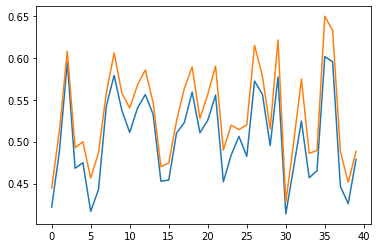

In [206]:
# plt.plot(content['trt']['rig']['cnt_ctrf'])
# plt.plot(content['trt']['rig']['cnt_rf'])

In [218]:
results['cn']['auc_sample']

0.8